In [1]:
import sys
#model_path = '/project2/andrewferguson/Kirill/OpticalMatterRL/experiments_2ndTo1st/target_1175_5e-5' # <-- bimodal
model_path = 'experiments/noPower_0.4_5e-5/'
sys.path.append(model_path)

from configparser import ConfigParser

from OpticalMatterEnv import OpticalMatterEnv
from OpticalMatterSim import OpticalMatterSim
from stable_baselines3 import PPO
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy

In [2]:
parser = ConfigParser()
parser.read(model_path + "/config.ini")

# env args
env_args = {
    "delta": parser.getfloat("env", "delta"),
    "episode_duration": parser.getint("env", "episode_duration"),
    "target": parser.getfloat("env", "target") * 1e-9,
    "n_past": parser.getint("env", "n_past"),
    "power_max": parser.getfloat("env", "power_max"),
    "n_steps": parser.getint("env", "n_steps"),
    "delta_power": parser.getfloat("env", "delta_power"),
    "use_power": parser.getboolean("env", "use_power")
}

# sim args
sim_args = {
    "width": parser.getfloat("sim", "width") * 1e-9,
    "power": parser.getfloat("sim", "power"),
    "rand_dist": parser.getboolean("sim", "rand_dist"),
    "dist_0": parser.getfloat('sim', 'dist_0') * 1e-9,
    #"rand_min": parser.getfloat('sim', 'rand_min') * 1e-9,
    #"rand_max": parser.getfloat('sim', 'rand_max') * 1e-9,
    #"noise_std": parser.getfloat('sim', 'noise_std') * 1e-9,
}
env_args["sim_kwargs"] = sim_args

In [3]:
env = OpticalMatterEnv(log=True, **env_args) #, env_kwargs={'n_steps':200})
sim = OpticalMatterSim(**sim_args)

In [4]:
sim_time =  30 # ms 
n_steps = round((sim_time * 1e-3) / sim.bd.dt)  
print(f'Simulating for {n_steps} steps')

Simulating for 6000 steps


In [5]:
ms2steps = lambda x : round((x * 1e-3) / sim.bd.dt)  

In [6]:
class Control:
    
    def __init__(self, sim_args):
        self.sim_args = sim_args
        self.pos = None
        self.dist_list = list()
        self.pos_list = list()
        self.time_list = list()
        
    def sim(self, n_steps, init_pos=None, anm=None, power=None):
        sim_args = copy.deepcopy(self.sim_args)
        if power is not None:
            sim_args['power'] = power
            
        if init_pos is None:
            if self.pos is None:
                simulator = OpticalMatterSim(**sim_args)
            else:
                simulator = OpticalMatterSim(**sim_args, initial=self.pos)
        else:
            simulator = OpticalMatterSim(**sim_args, initial=init_pos)
        
        if anm is not None:
            simulator.setCoeffs(anm, simulator.source.power)
            
        simulator.sim(n_steps)
        self.dist_list.append(simulator.dist)
        self.pos_list.append(simulator.pos)
        self.pos = simulator.bd.position
        
    def alternate_beam(self, anm_0, anm_1, n_steps, n_iters):
        for _ in tqdm(range(n_iters), leave=False):
            self.sim(n_steps, anm=anm_0)
            self.sim(n_steps, anm=anm_1)
    
    def catch(self, dist, n_steps_interval):
        mask = 1
        while mask:
            self.sim(n_steps_interval, power=0.0)
            
            if self.global_dist[-1] > dist:
                mask = 0
            
            #print(f'Dist: {round(self.global_dist[-1] / 1e-9, 4)} nm')
    
    def time_log(self, dt=5000 * 1e-9):
        self.time_list.append(self.global_dist.shape[0] * dt)
    
    
    def control_sequence(self, 
                         n_sequences,
                         anm_0, anm_1,
                         anm_null,
                         n_steps_actuate,
                         n_iters_actuate,
                         n_steps_null,
                         catch_dist,
                         catch_steps):
        
        for _ in tqdm(range(n_sequences)):
            print('Actuacting...')
            control.alternate_beam(anm_0, anm_1, n_steps_actuate, n_iters_actuate)
            self.time_log()
            print('Simple beam...')
            control.sim(n_steps_null, anm=anm_null)
            self.time_log()
            print('Catching...')
            control.catch(catch_dist, catch_steps)
            self.time_log()
            
            self.center_pos()
        
        control.alternate_beam(anm_0, anm_1, n_steps_actuate, n_iters_actuate)
        self.time_log()
    
    def center_pos(self):
        self.pos = self.pos - self.pos.mean(axis=0, keepdims=True)
    
    @property
    def global_dist(self):
        return np.concatenate(self.dist_list)
    
    @property
    def global_pos(self):
        return np.concatenate(self.pos_list)
    
    @property
    def global_time(self):
        return np.array(self.time_list) * 1000
        

In [7]:
control = Control(sim_args)

In [8]:
anm_0 = np.array([ 0.        ,  0.        , -5.18690395,  3.86408979,  6.45728607])
anm_1 = np.array([ 0.        ,  0.        ,  9.81309605,  4.9378089 , -8.54271393])
anm_const = np.array([ 0.        ,  0.        ,  -0.8921,  0.1325 , 2.3858])
anm_null = np.zeros(5)
power = 0.4
power_null = 0.0

In [28]:
control.control_sequence(n_sequences=1,
                         anm_0=anm_0, 
                         anm_1=anm_1,
                         anm_null=anm_null,
                         n_steps_actuate=ms2steps(1),
                         n_iters_actuate=20,
                         n_steps_null=ms2steps(40),
                         catch_dist=1300 * 1e-9,
                         catch_steps=ms2steps(1))

Actuacting...


Simple beam...
Catching...



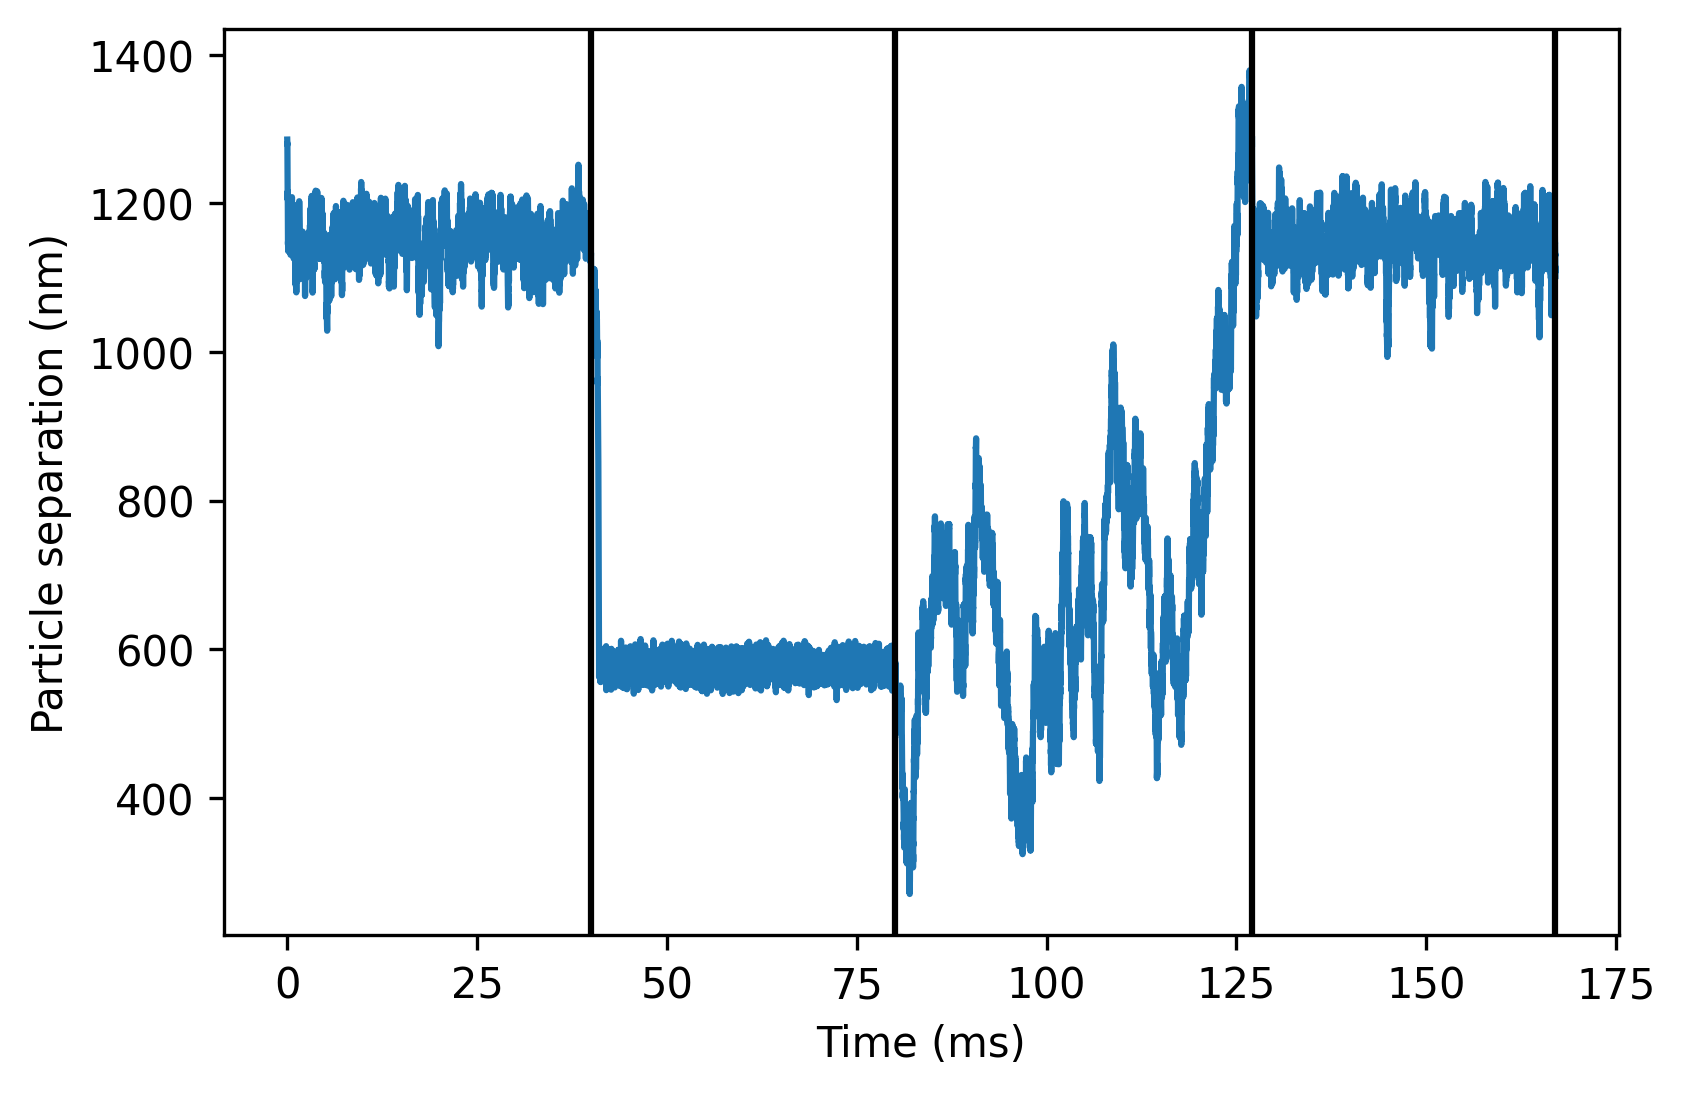

In [29]:
plt.figure(dpi=300)
x = np.linspace(0, sim.bd.dt * control.global_dist.size * 1000, control.global_dist.size)
plt.plot(x, control.global_dist / 1e-9)
plt.xlabel('Time (ms)')
plt.ylabel('Particle separation (nm)')
for val in control.global_time:
    plt.axvline(x=val, c='k')

In [43]:
control.control_sequence(n_sequences=4,
                         anm_0=anm_0, 
                         anm_1=anm_1,
                         anm_null=anm_null,
                         n_steps_actuate=ms2steps(1),
                         n_iters_actuate=20,
                         n_steps_null=ms2steps(40),
                         catch_dist=1300 * 1e-9,
                         catch_steps=ms2steps(1))

Actuacting...


Simple beam...
Catching...
Actuacting...


Simple beam...
Catching...
Actuacting...


Simple beam...
Catching...
Actuacting...


Simple beam...
Catching...



In [22]:
control.control_sequence(n_sequences=4,
                         anm_0=anm_0, 
                         anm_1=anm_0,
                         anm_null=anm_null,
                         n_steps_actuate=ms2steps(1),
                         n_iters_actuate=20,
                         n_steps_null=ms2steps(40),
                         catch_dist=1300 * 1e-9,
                         catch_steps=ms2steps(1))

Actuacting...


Simple beam...
Catching...
Actuacting...


Simple beam...
Catching...
Actuacting...


Simple beam...
Catching...
Actuacting...


Simple beam...
Catching...



Text(0, 0.5, 'Particle separation (nm)')

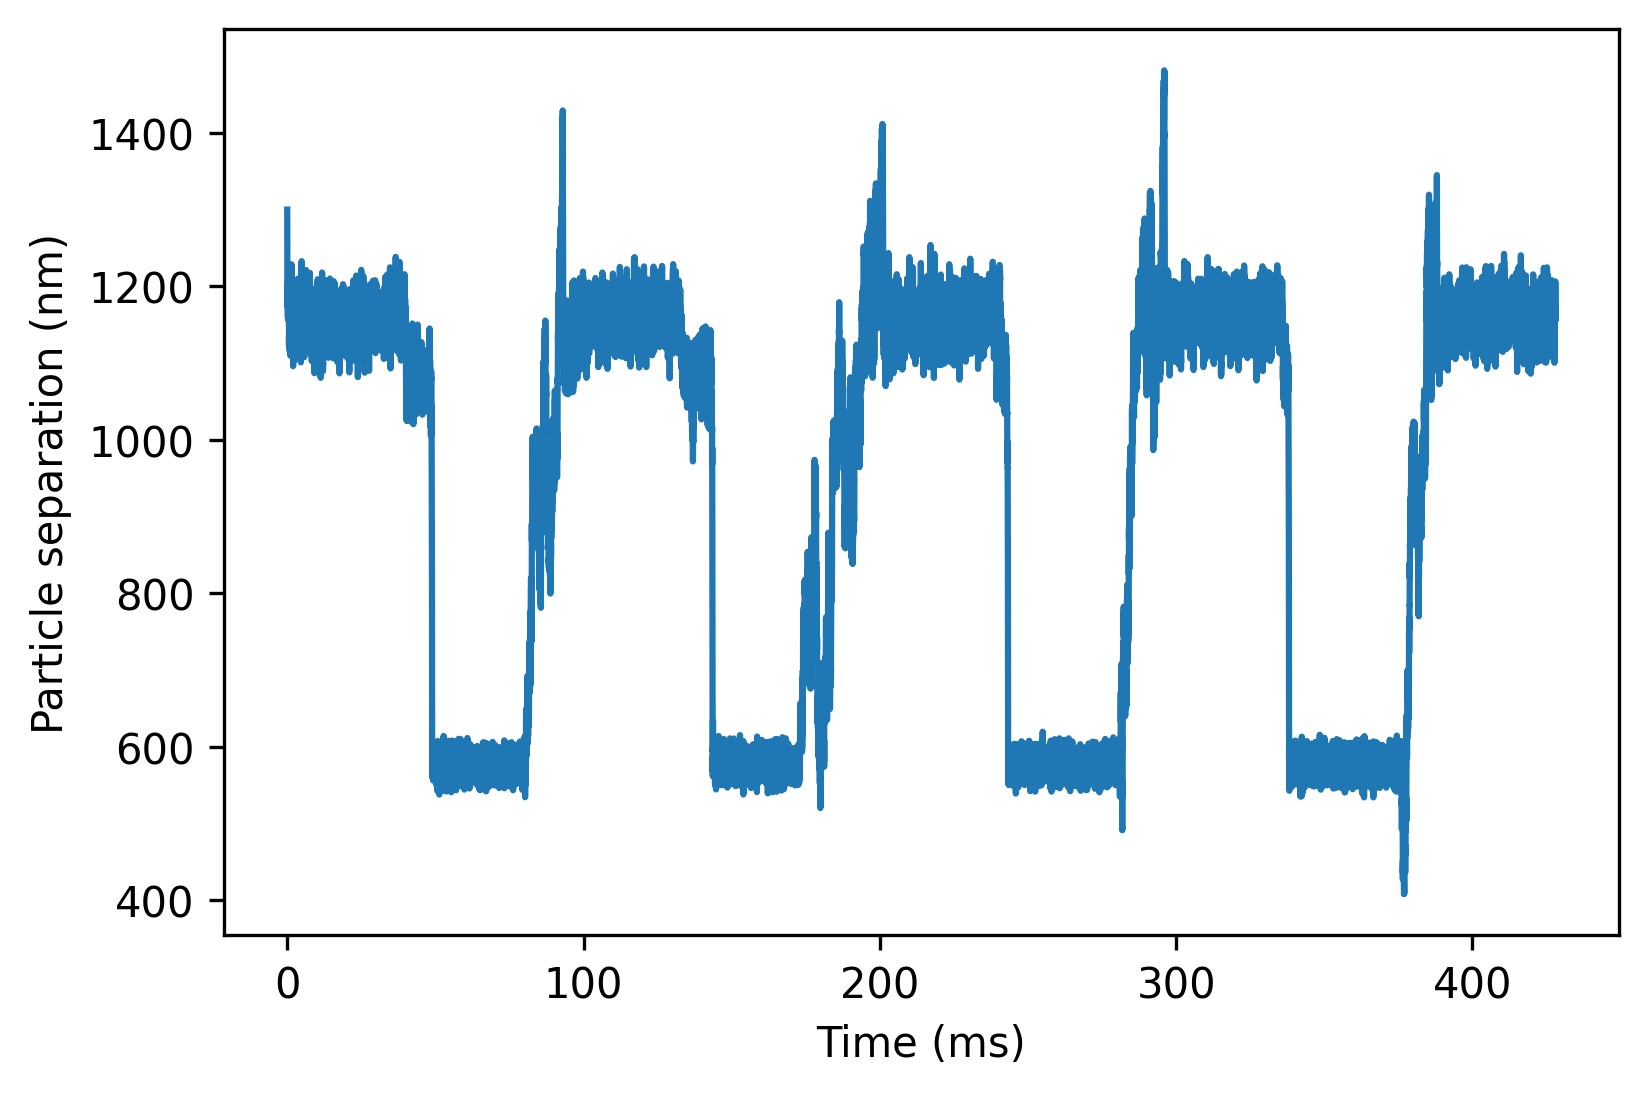

In [24]:
plt.figure(dpi=300)
x = np.linspace(0, sim.bd.dt * control.global_dist.size * 1000, control.global_dist.size)
plt.plot(x, control.global_dist / 1e-9)
plt.xlabel('Time (ms)')
plt.ylabel('Particle separation (nm)')
#for val in control.global_time:
#    plt.axvline(x=val, c='k')

In [25]:
control.control_sequence(n_sequences=4,
                         anm_0=anm_1, 
                         anm_1=anm_1,
                         anm_null=anm_null,
                         n_steps_actuate=ms2steps(1),
                         n_iters_actuate=20,
                         n_steps_null=ms2steps(40),
                         catch_dist=1300 * 1e-9,
                         catch_steps=ms2steps(1))

Actuacting...


Simple beam...
Catching...
Actuacting...


Simple beam...
Catching...
Actuacting...


Simple beam...
Catching...
Actuacting...


Simple beam...
Catching...



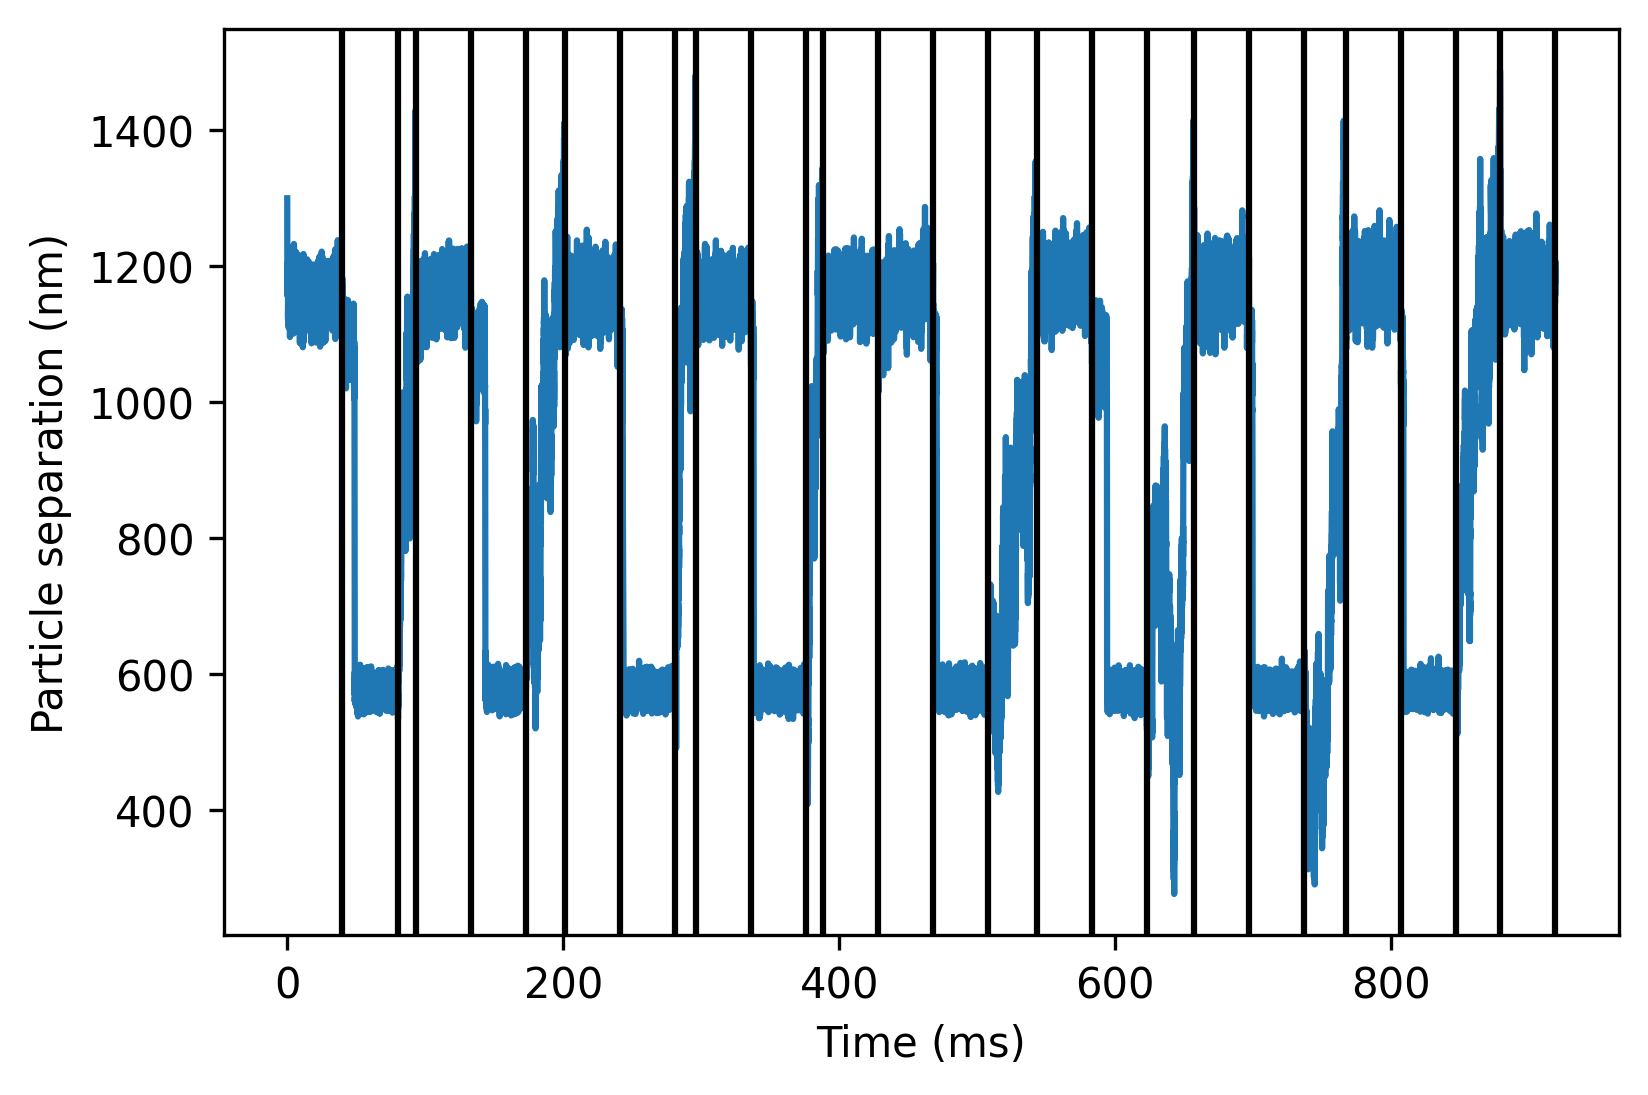

In [27]:
plt.figure(dpi=300)
x = np.linspace(0, sim.bd.dt * control.global_dist.size * 1000, control.global_dist.size)
plt.plot(x, control.global_dist / 1e-9)
plt.xlabel('Time (ms)')
plt.ylabel('Particle separation (nm)')
#for val in control.global_time:
#    plt.axvline(x=val, c='k')

In [9]:
control = Control(sim_args)
control.sim(ms2steps(5000), anm=anm_0, power=0.4)

Text(0, 0.5, 'Particle separation (nm)')

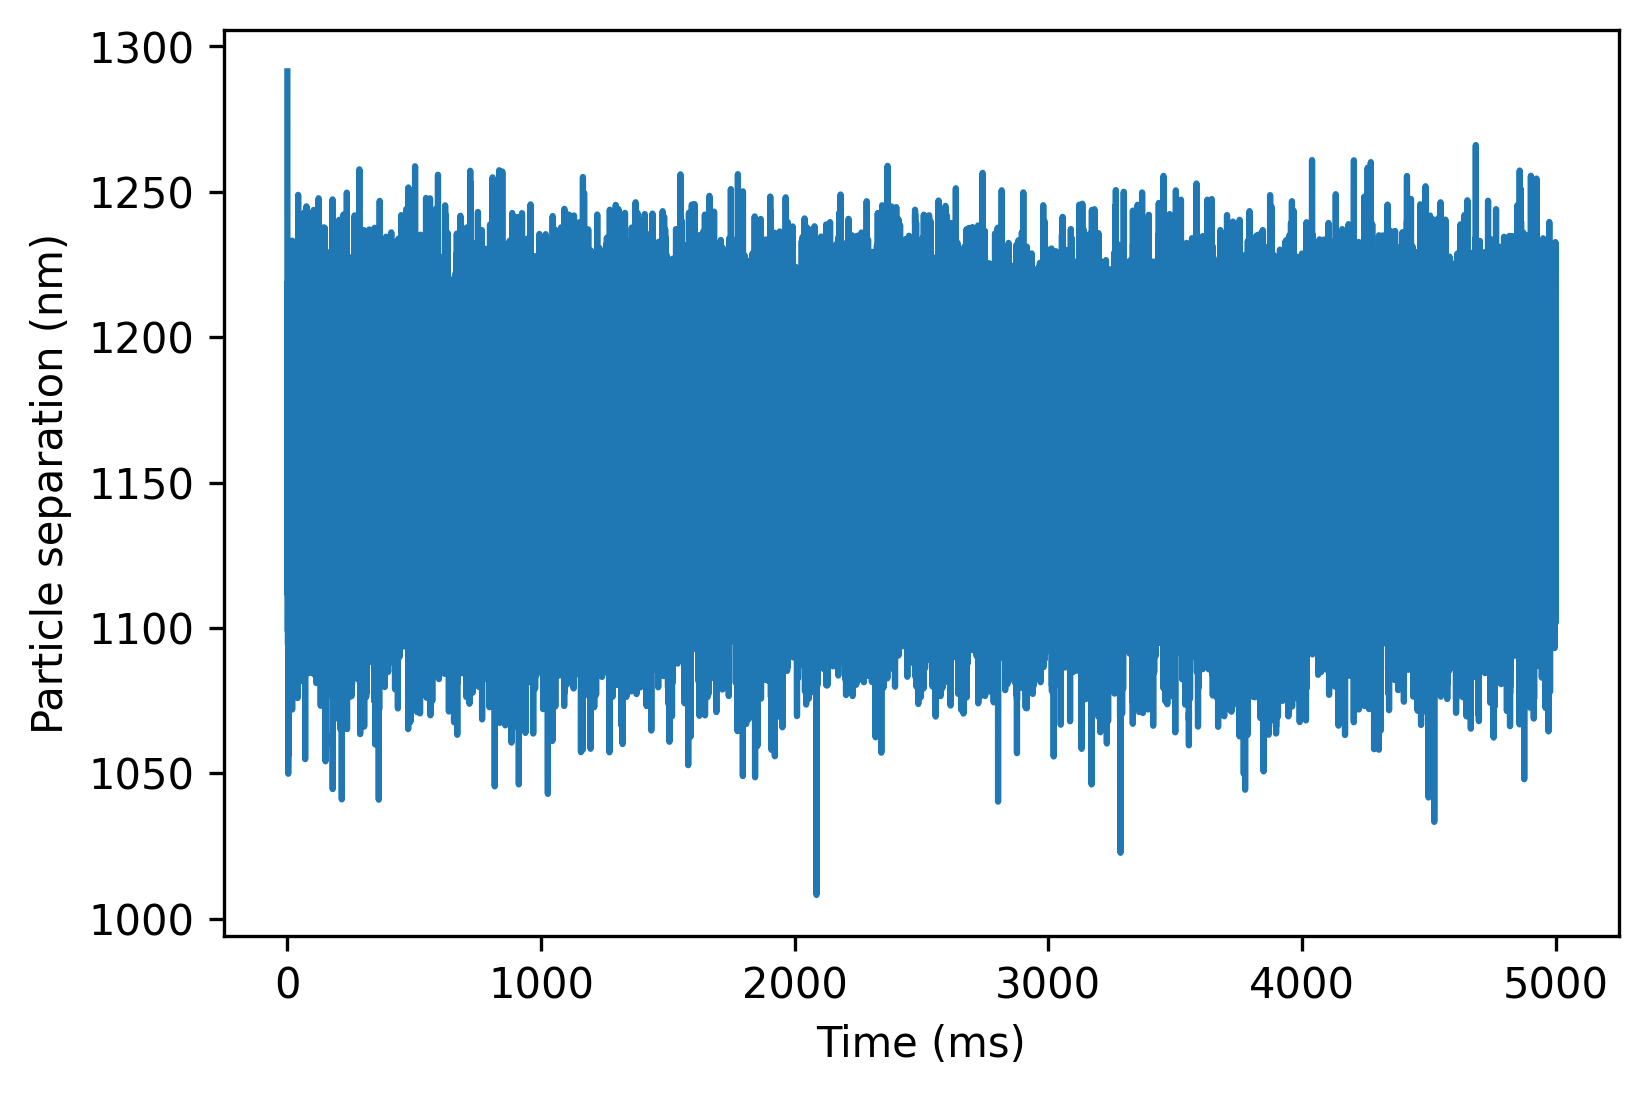

In [10]:
plt.figure(dpi=300)
x = np.linspace(0, sim.bd.dt * control.global_dist.size * 1000, control.global_dist.size)
plt.plot(x, control.global_dist / 1e-9)
plt.xlabel('Time (ms)')
plt.ylabel('Particle separation (nm)')
#for val in control.global_time:
#    plt.axvline(x=val, c='k')

In [11]:
control = Control(sim_args)
control.sim(ms2steps(5000), anm=anm_1, power=0.4)

Text(0, 0.5, 'Particle separation (nm)')

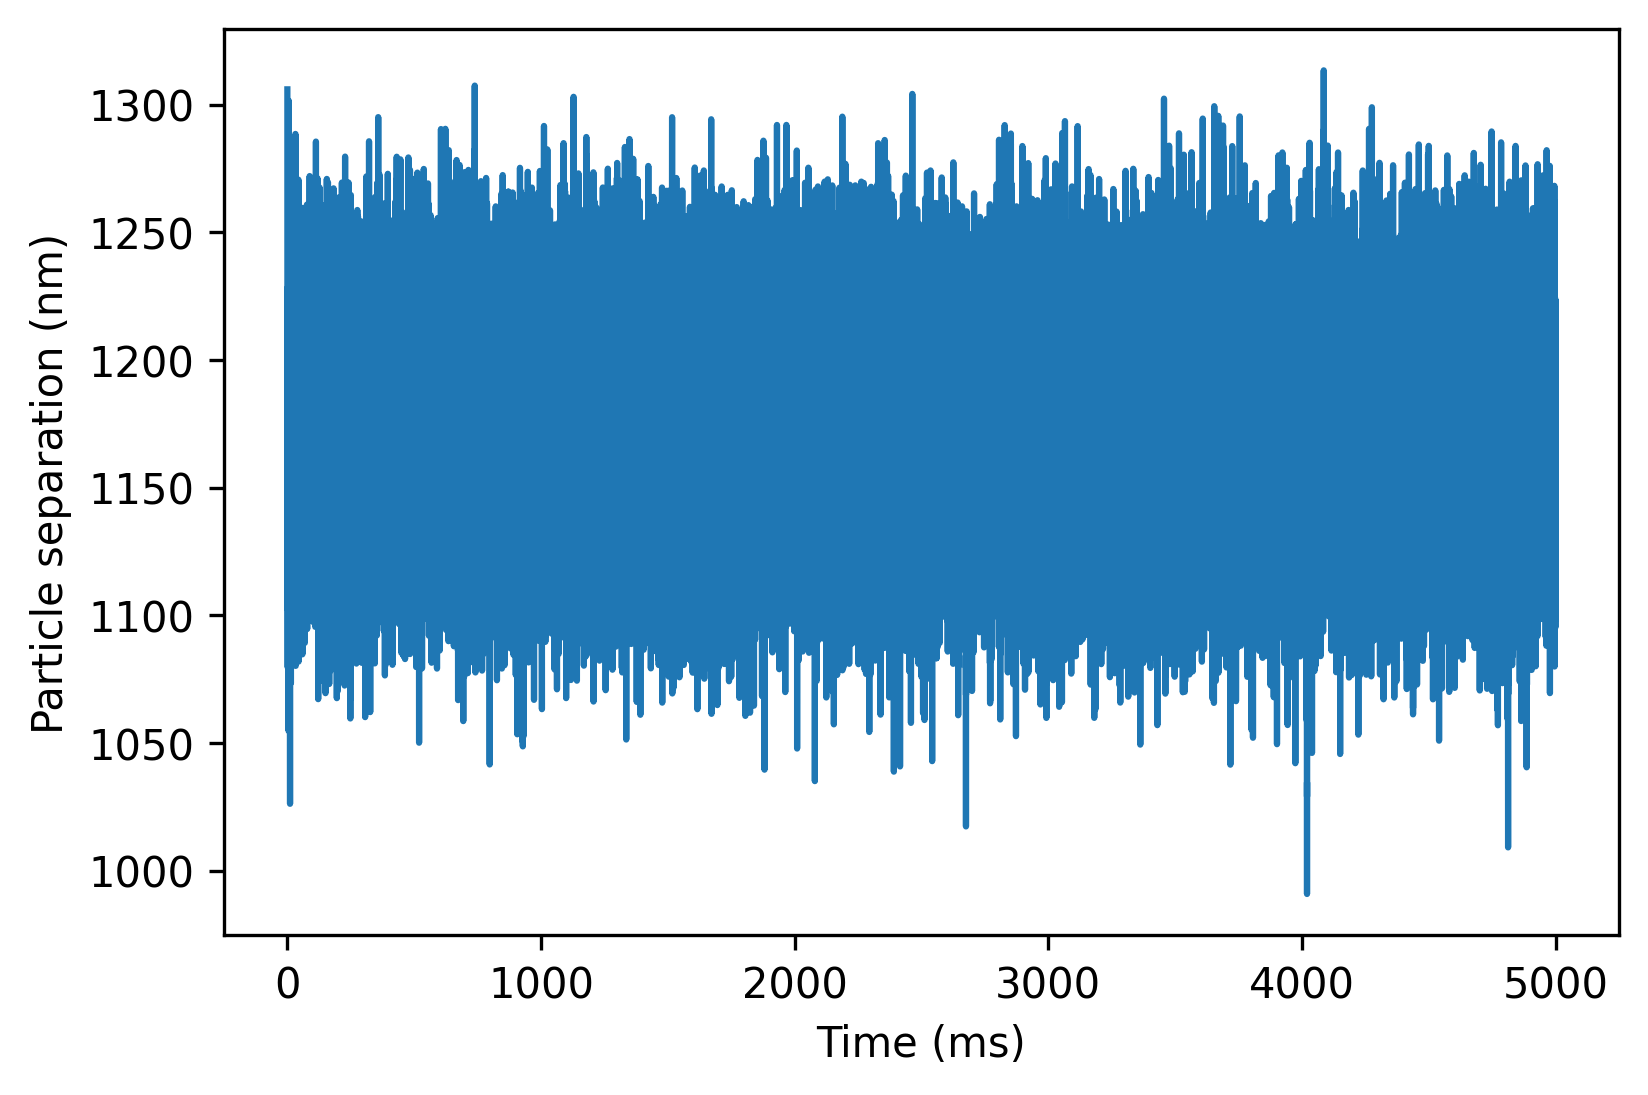

In [12]:
plt.figure(dpi=300)
x = np.linspace(0, sim.bd.dt * control.global_dist.size * 1000, control.global_dist.size)
plt.plot(x, control.global_dist / 1e-9)
plt.xlabel('Time (ms)')
plt.ylabel('Particle separation (nm)')
#for val in control.global_time:
#    plt.axvline(x=val, c='k')

In [34]:
control = Control(sim_args)
control.alternate_beam(anm_0=anm_0, anm_1=anm_1, n_steps=ms2steps(10), n_iters=25)

Text(0, 0.5, 'Particle separation (nm)')

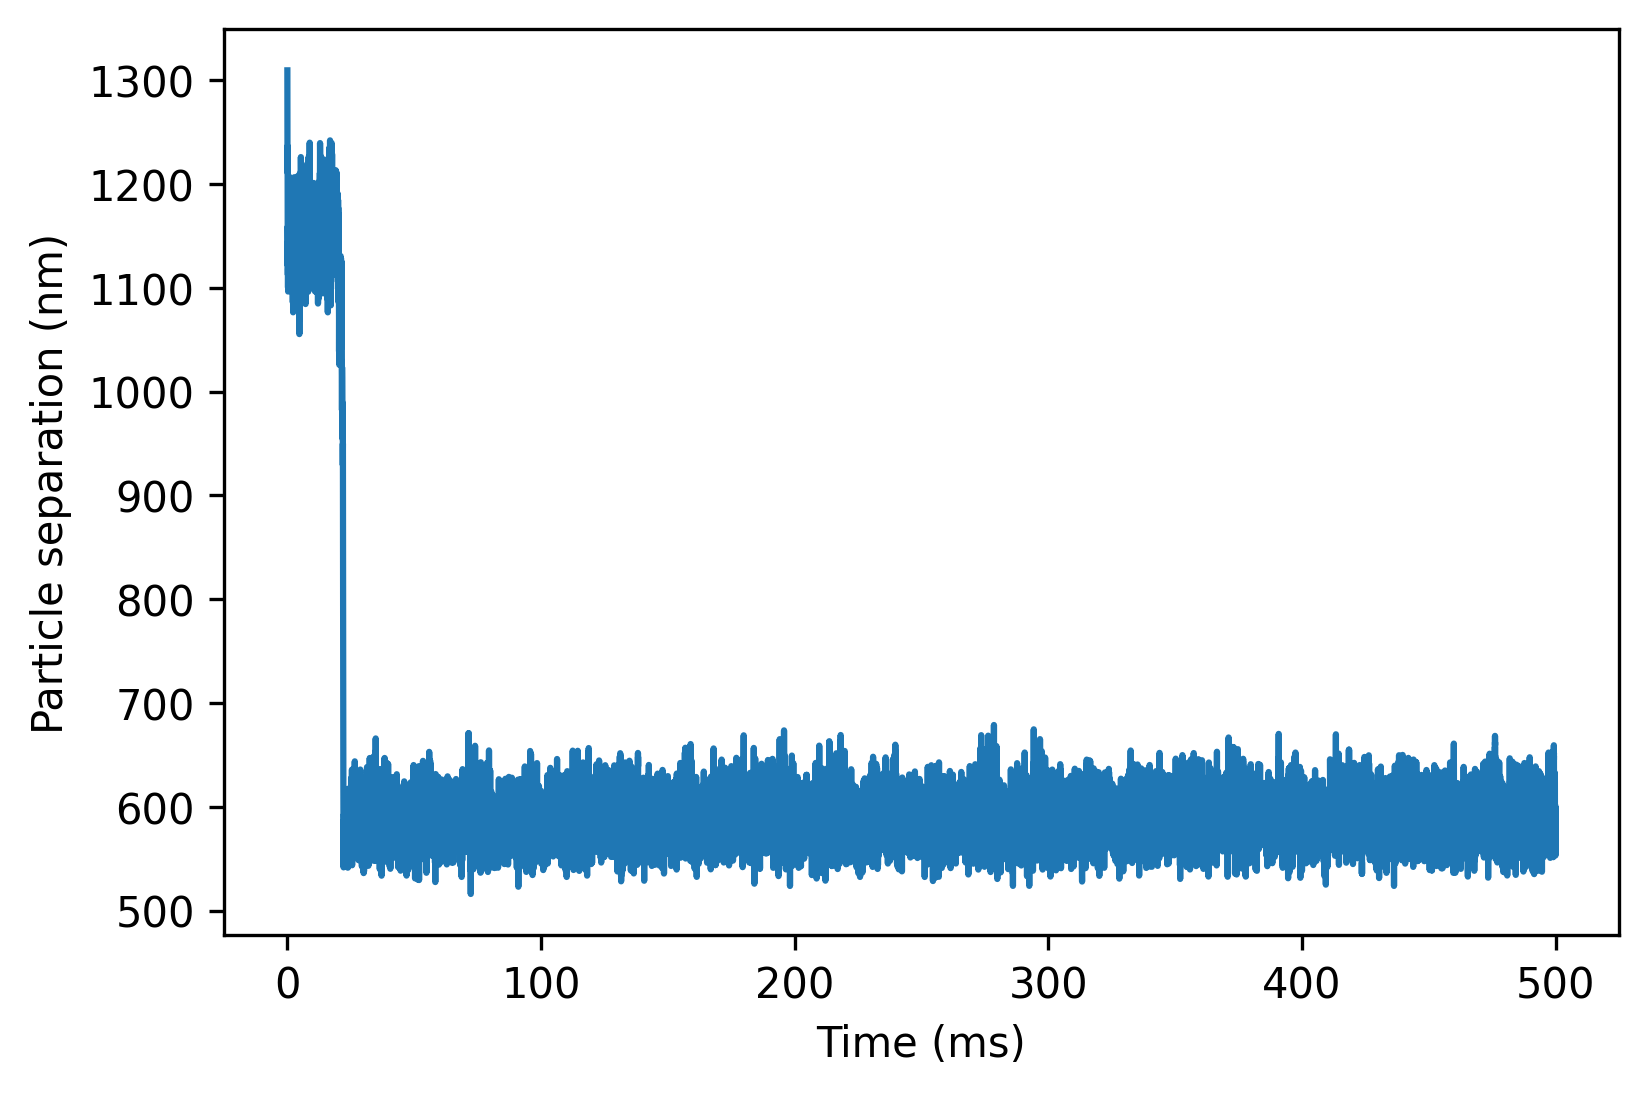

In [35]:
plt.figure(dpi=300)
x = np.linspace(0, sim.bd.dt * control.global_dist.size * 1000, control.global_dist.size)
plt.plot(x, control.global_dist / 1e-9)
plt.xlabel('Time (ms)')
plt.ylabel('Particle separation (nm)')
#for val in control.global_time:
#    plt.axvline(x=val, c='k')

In [11]:
sim_args['power'] = 0.3
control = Control(sim_args)

In [10]:
control.control_sequence(n_sequences=1,
                         anm_0=anm_const, 
                         anm_1=anm_const,
                         anm_null=anm_null,
                         n_steps_actuate=ms2steps(1),
                         n_iters_actuate=20,
                         n_steps_null=ms2steps(40),
                         catch_dist=1200 * 1e-9,
                         catch_steps=ms2steps(1))

Actuacting...


KeyboardInterrupt: 

In [ ]:
plt.figure(dpi=300)
x = np.linspace(0, sim.bd.dt * control.global_dist.size * 1000, control.global_dist.size)
plt.plot(x, control.global_dist / 1e-9)
plt.xlabel('Time (ms)')
plt.ylabel('Particle separation (nm)')

In [12]:
control.control_sequence(n_sequences=4,
                         anm_0=anm_const, 
                         anm_1=anm_const,
                         anm_null=anm_null,
                         n_steps_actuate=ms2steps(1),
                         n_iters_actuate=20,
                         n_steps_null=ms2steps(40),
                         catch_dist=1200 * 1e-9,
                         catch_steps=ms2steps(1))

Actuacting...


Simple beam...
Catching...
Actuacting...


Simple beam...
Catching...
Actuacting...


Simple beam...
Catching...
Actuacting...


Simple beam...
Catching...



Text(0, 0.5, 'Particle separation (nm)')

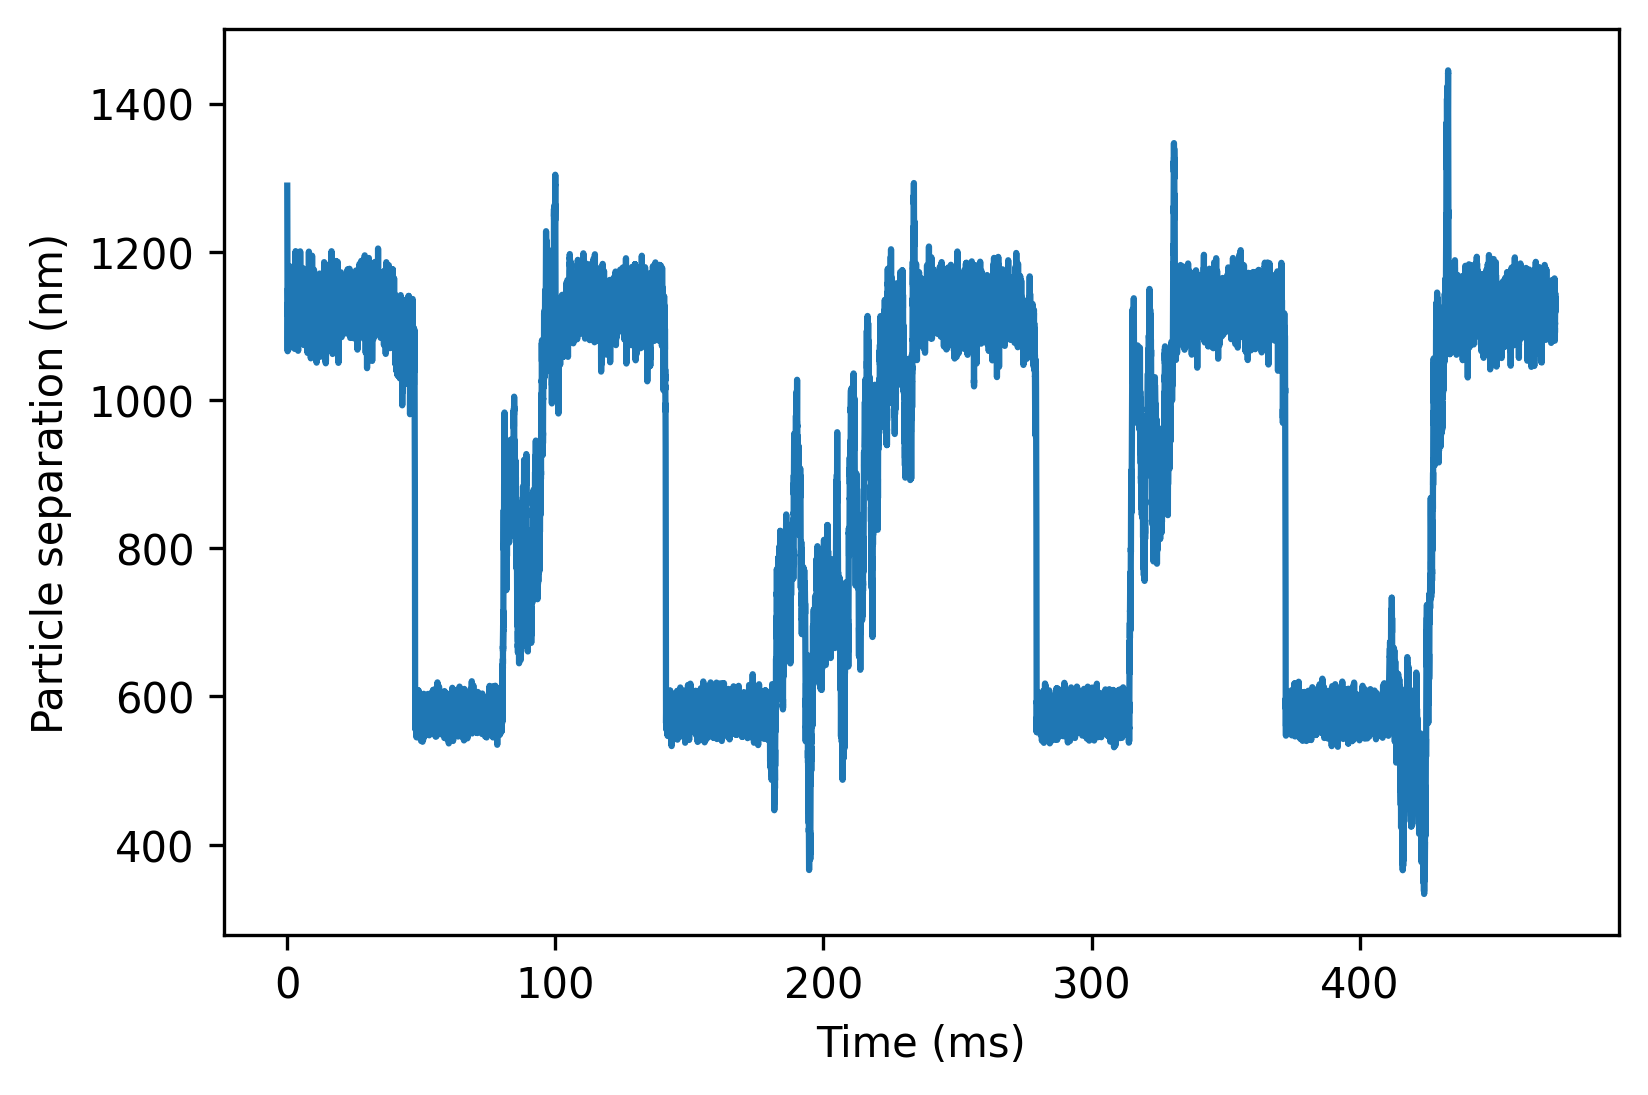

In [13]:
plt.figure(dpi=300)
x = np.linspace(0, sim.bd.dt * control.global_dist.size * 1000, control.global_dist.size)
plt.plot(x, control.global_dist / 1e-9)
plt.xlabel('Time (ms)')
plt.ylabel('Particle separation (nm)')
#for val in control.global_time:
#    plt.axvline(x=val, c='k')

In [40]:
sim.source 

phase-only SLM modified gaussian_beam(width=1.5e-06, polarization=[0.70710678+0.j         0.        +0.70710678j], power=0.4, center=[0. 0. 0.], theta=0, phi=0)

In [13]:
from copy import deepcopy

In [14]:
sim_0 = deepcopy(sim)
sim_1 = deepcopy(sim)

In [18]:
import miepy
from topics.optical_matter.dynamics import stoked_from_cluster_2d
nm = ns = 1e-9
Ag = miepy.materials.Ag()
water = miepy.materials.water()
radius = 75 * nm
width = sim_args['width']
wavelength = 800 * nm
polarization = [1, 1j]

Nmax = 2  # max order in Zernike polynomial
rho_scale = 3  # scale the rho values in Znm





anm_size = int((Nmax + 1) * (Nmax + 2) / 2) - 1
anm = np.zeros([anm_size], dtype=float)  # coefficient array

e_field_sampling = 50  # angular resolution of the SLM

# dependent variables (don't change)
k = 2 * np.pi * 1.33 / wavelength
lmax = 2

source_0 = miepy.sources.gaussian_beam(
    width, polarization=polarization, power=power
)
sim_0.anm = anm_0
source_0 = miepy.sources.phase_only_slm(source_0, sim_0.slm)

source_1 = miepy.sources.gaussian_beam(
    width, polarization=polarization, power=power
)
sim_1.anm = anm_1
source_1 = miepy.sources.phase_only_slm(source_1, sim_1.slm)

source = source_0 + source_1

dist_0 = 1300 * nm
theta = np.random.uniform() * np.pi
x = (dist_0 / 2.0) * np.cos(theta)
y = (dist_0 / 2.0) * np.sin(theta)

initial = [
    [x, y, 0.0],
    [-x, -y, 0.0],
]


cluster = miepy.sphere_cluster(
    position=initial,
    radius=radius,
    material=Ag,
    lmax=lmax,
    source=source,
    wavelength=wavelength,
    medium=water,
)
bd = stoked_from_cluster_2d(cluster, dt=5000 * ns)

In [19]:
cluster = miepy.sphere_cluster(
    position=initial,
    radius=radius,
    material=Ag,
    lmax=lmax,
    source=source,
    wavelength=wavelength,
    medium=water,
)
bd = stoked_from_cluster_2d(cluster, dt=5000 * ns)

In [20]:
n_steps = int(ms2steps(1000))
pos = np.empty((n_steps, 2, 3))
for i in tqdm(range(n_steps)):
    bd.step()
    pos[i] = bd.position

In [21]:
dist = np.linalg.norm(pos[:, 0] - pos[:, 1], axis=-1)

Text(0.5, 1.0, 'Superposition of two-beam solution')

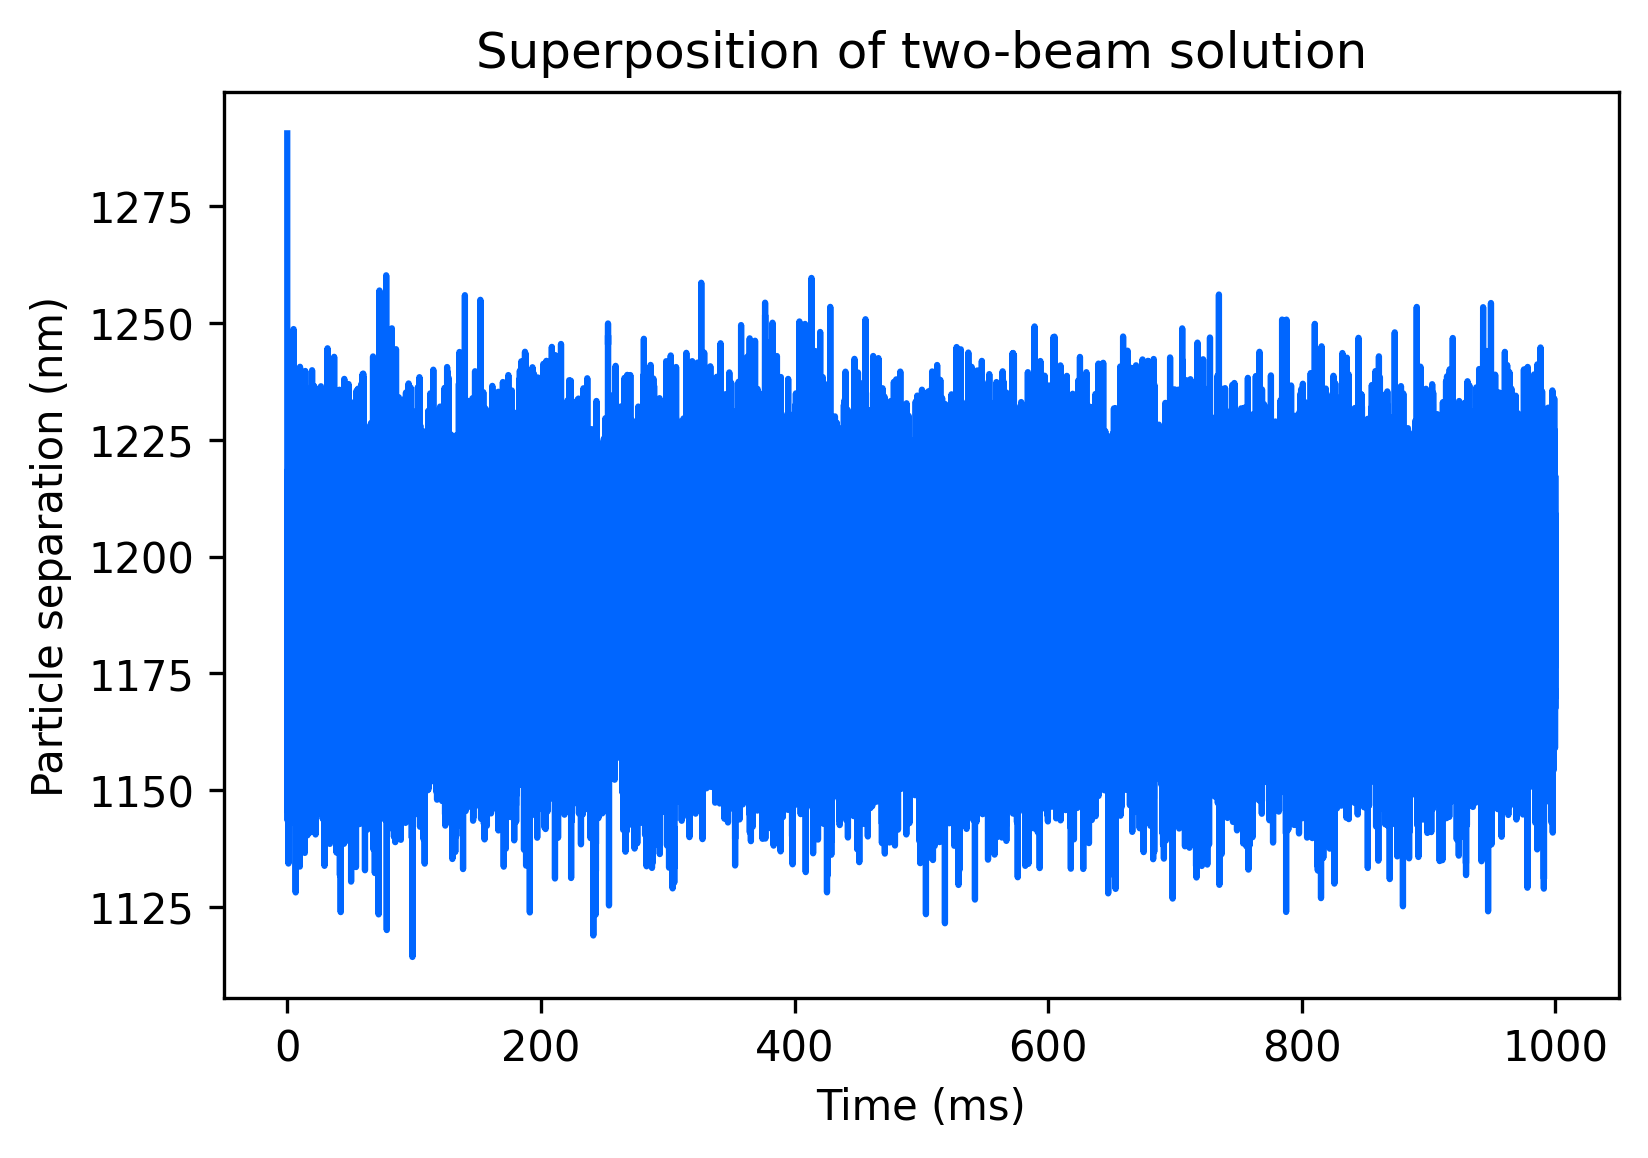

In [35]:
plt.figure(dpi=300)
x = np.linspace(0, bd.dt * dist.size * 1000, dist.size)
plt.plot(x, dist / 1e-9)
plt.xlabel('Time (ms)')
plt.ylabel('Particle separation (nm)')
plt.title('Superposition of two-beam solution')

In [23]:
nm = 1e-9
size = 12000*nm
Nx = 64

### X,Y grid for computing fields
x = np.linspace(-size/2, size/2, Nx)
y = np.linspace(-size/2, size/2, Nx)
X, Y = np.meshgrid(x, y, indexing='ij')
Z = np.zeros_like(X)

In [26]:
def fields(sim):
    """calculate the focal (electric) fields"""
    E = sim.source.E_field(X, Y, Z, sim.k, sampling=sim.e_field_sampling)
    I = np.sum(np.abs(E)**2, axis=0)
    return I / I.max()

def fields_2source(source, sim):
    """calculate the focal (electric) fields"""
    E = source.E_field(X, Y, Z, sim.k)#, sampling=sim.e_field_sampling)
    I = np.sum(np.abs(E)**2, axis=0)
    return I / I.max()

In [103]:
sim.setCoeffs(anm_1, sim.source.power)
I = fields(sim)

In [27]:
I = fields_2source(source, sim)

In [28]:
from my_pytools.my_matplotlib.colors import cmap
import matplotlib

In [105]:
pos = control.global_pos[19999 + 1]

In [49]:
np.arange(pos.shape[0], step=100).shape[0]

2000

In [ ]:
for i, step in tqdm(enumerate(np.arange(pos.shape[0], step=100)), total=np.arange(pos.shape[0], step=100).shape[0]):
    fig, ax = plt.subplots(dpi=300)
    im = ax.pcolormesh(X / nm, Y / nm, I, cmap=cmap['parula'], vmax=np.max(I), shading='gouraud', norm=matplotlib.colors.Normalize())
    ax.set_aspect('equal')
    C1 = plt.Circle(pos[step][0,:2]/nm, radius=sim.radius / nm, color='C3')
    C2 = plt.Circle(pos[step][1,:2]/nm, radius=sim.radius / nm, color='C3')
    ax.add_patch(C1)
    ax.add_patch(C2)
    ax.set_xlabel('x (nm)')
    ax.set_ylabel('x (nm)')
    plt.savefig(f'mov/step_{i:04d}.png')